# 📊 Análise Inicial dos Logs

In [1]:
!pip install plotly openpyxl


📁 Arquivo Excel gerado com sucesso.


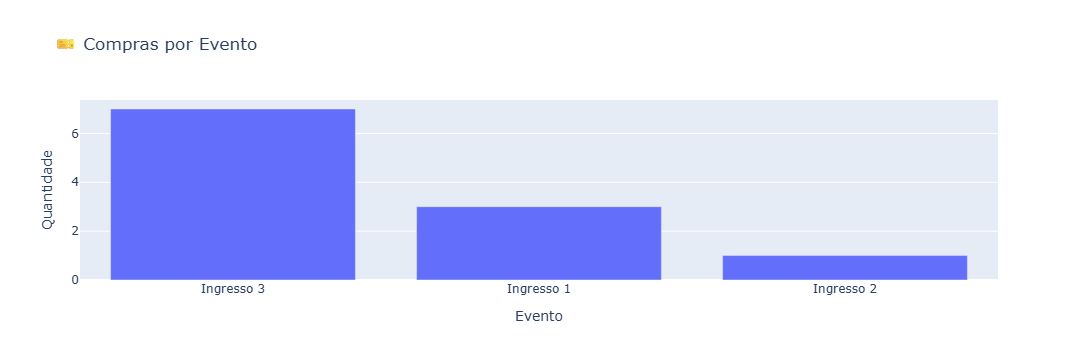

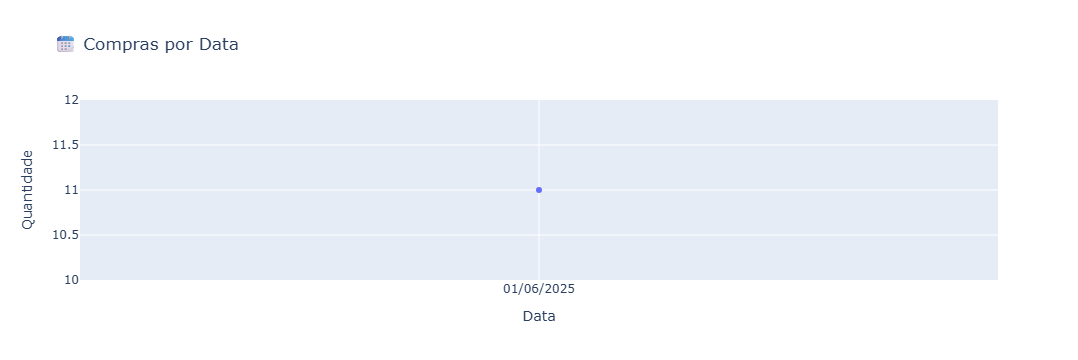

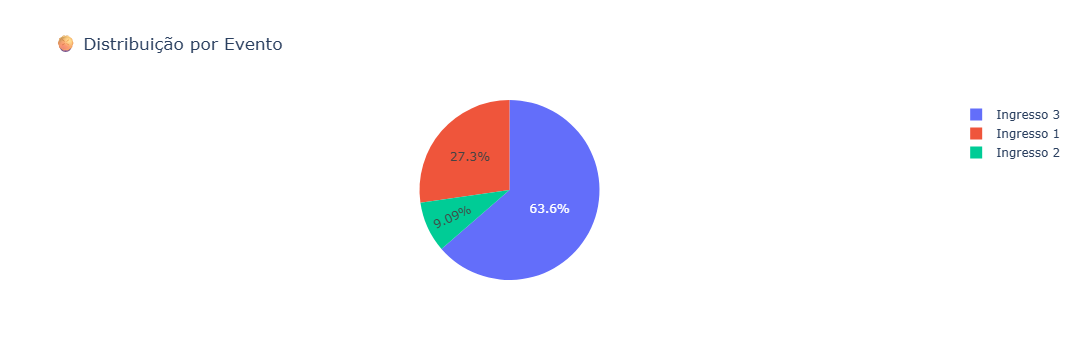

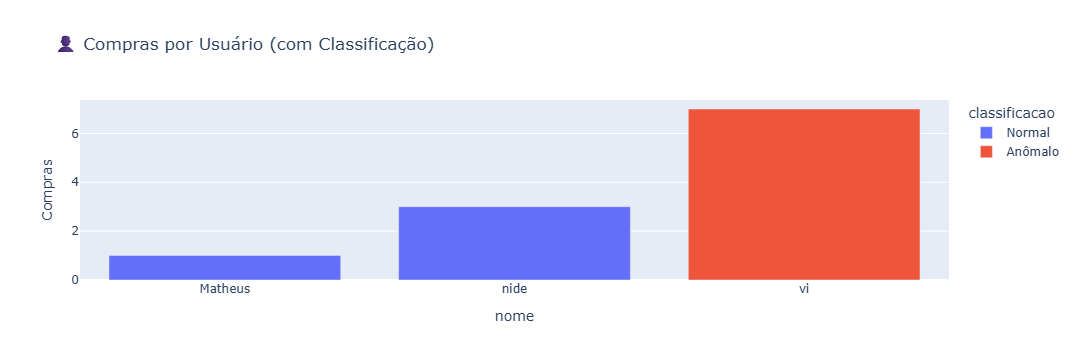


✅ Pipeline finalizada com sucesso!
    usuario_id     nome classificacao
0            1     nide        Normal
3            2       vi       Anômalo
10           3  Matheus        Normal


In [2]:
import sqlite3
import pandas as pd
import plotly.express as px
from sklearn.ensemble import IsolationForest

# 📥 Carregar dados de compras de ingressos com classificação por IA
def carregar_dados_ingressos_com_ia():
    conn = sqlite3.connect("../database.db")  # Ajuste o caminho se necessário
    query = """
        SELECT u.id AS usuario_id, u.nome, u.email, l.acao_usuario as acao, l.data_hora
        FROM logs l
        JOIN usuarios u ON u.id = l.usuario_id
        WHERE l.acao_usuario LIKE 'Compra do ingresso ID%'
    """
    df = pd.read_sql_query(query, conn)
    conn.close()

    df['data_hora'] = pd.to_datetime(df['data_hora'])
    df['evento'] = df['acao'].str.replace("Compra do ingresso ID ", "Ingresso ")
    df['data'] = df['data_hora'].dt.date

    # 🧠 Isolation Forest
    df_features = df.groupby(['usuario_id', 'nome', 'email']).agg(
        total_compras=('evento', 'count'),
        dias_diferentes=('data', pd.Series.nunique)
    ).reset_index()

    modelo = IsolationForest(contamination=0.15, random_state=42)
    df_features['classificacao'] = modelo.fit_predict(df_features[['total_compras', 'dias_diferentes']])
    df_features['classificacao'] = df_features['classificacao'].map({1: 'Normal', -1: 'Anômalo'})

    df = pd.merge(df, df_features[['usuario_id', 'classificacao']], on='usuario_id', how='left')
    return df

# 📊 Exibir gráficos
def exibir_graficos(df):
    contagem_eventos = df['evento'].value_counts().reset_index()
    contagem_eventos.columns = ['Evento', 'Quantidade']
    px.bar(contagem_eventos, x='Evento', y='Quantidade', title='🎫 Compras por Evento').show()

    compras_por_data = df['data'].value_counts().sort_index().reset_index()
    compras_por_data.columns = ['Data', 'Quantidade']
    compras_por_data['Data'] = compras_por_data['Data'].apply(lambda d: d.strftime('%d/%m/%Y'))
    px.line(compras_por_data, x='Data', y='Quantidade', markers=True, title='📆 Compras por Data').show()

    px.pie(contagem_eventos, names='Evento', values='Quantidade', title='🥧 Distribuição por Evento').show()

    compras_por_usuario = df.groupby(['nome', 'classificacao'])['evento'].count().reset_index(name='Compras')
    px.bar(compras_por_usuario, x='nome', y='Compras', color='classificacao',
           title='👤 Compras por Usuário (com Classificação)').show()

# 🚀 Executar pipeline
def executar_pipeline():
    df = carregar_dados_ingressos_com_ia()

    df.to_csv("compras_ingressos_ia.csv", index=False, encoding="utf-8-sig")
    try:
        df.to_excel("compras_ingressos_ia.xlsx", index=False)
        print("📁 Arquivo Excel gerado com sucesso.")
    except Exception as e:
        print(f"⚠️ Erro ao gerar Excel: {e}")

    exibir_graficos(df)

    print("\n✅ Pipeline finalizada com sucesso!")
    print(df[['usuario_id', 'nome', 'classificacao']].drop_duplicates())

# ▶️ Rodar como script principal
if __name__ == "__main__":
    executar_pipeline()
